1. Compute the $X_{cp}$ matrix from the employment data

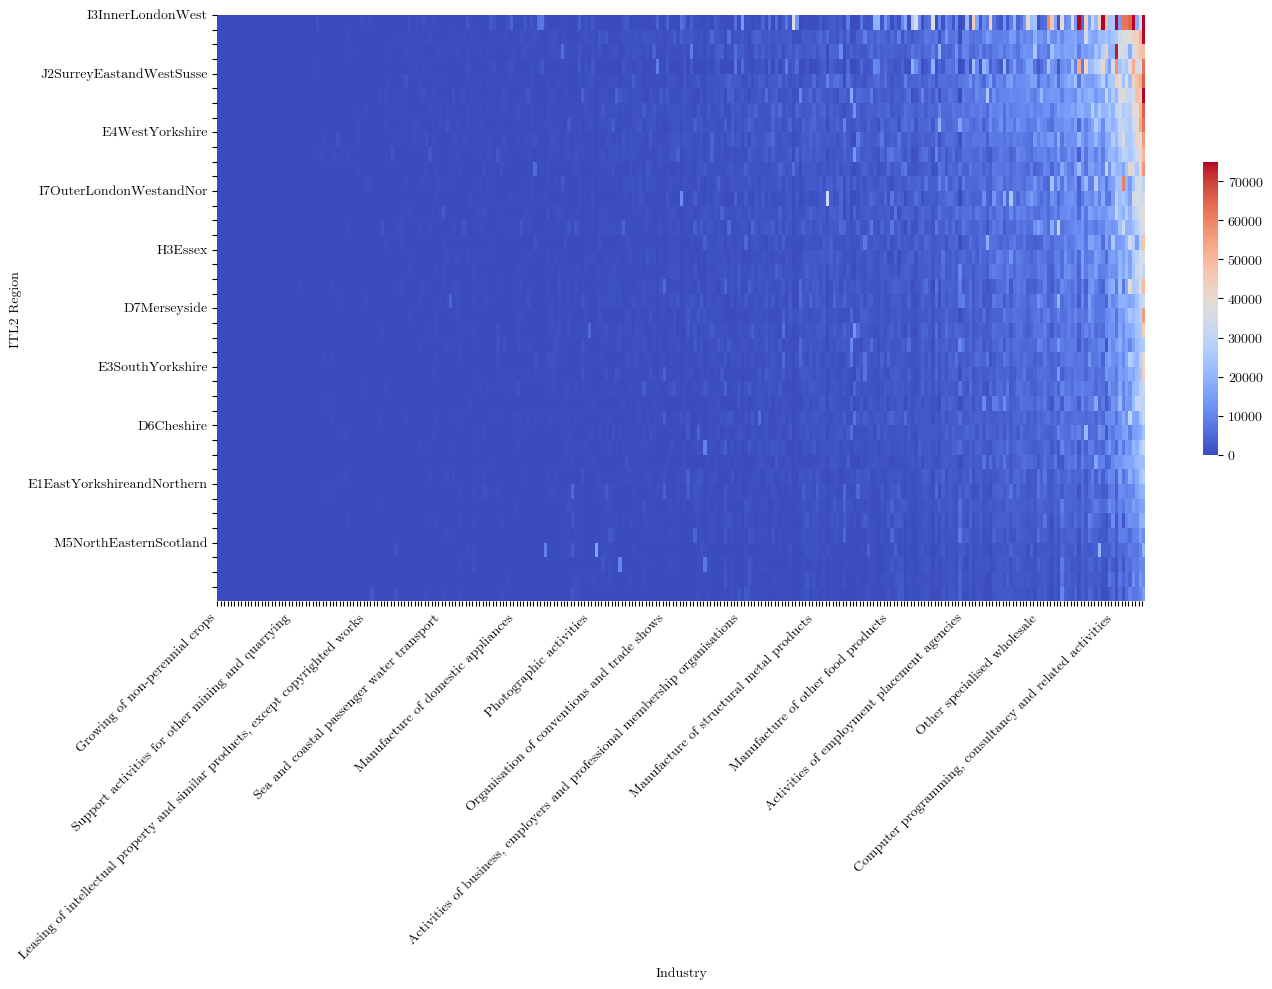

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import numpy as np

plt.rcParams.update({'font.family': 'CMU Serif'})

# Load data
data_path = 'employment_region.csv'  
employment_data = pd.read_csv(data_path)

# Correcting industry names
employment_data['industry'] = employment_data['industry'].apply(lambda x: x.split(': ', 1)[-1] if ': ' in x else x.split(':', 1)[-1])

# Aggregate and sort data 
total_employment_by_region = employment_data.groupby('itl2')['employment'].sum().sort_values(ascending=False)
total_employment_by_industry = employment_data.groupby('industry')['employment'].sum().sort_values(ascending=True)

# Pivot the data
pivot_table_modified = employment_data.pivot_table(index="itl2", columns="industry", values="employment", aggfunc="sum")\
                                       .reindex(index=total_employment_by_region.index, columns=total_employment_by_industry.index)

# Custom colormap and normalisation for the heatmap
norm = Normalize(vmin=pivot_table_modified.min().min(), vmax=75000)
colors = plt.cm.coolwarm(np.linspace(0, 1, 256))
new_colors = colors[np.linspace(0, 255, 256, endpoint=True, dtype=int)]
custom_colormap = ListedColormap(new_colors)

# Generate and apply selective labels for regions and industries
regions = pivot_table_modified.index.tolist()
industries = pivot_table_modified.columns.tolist()
nth_region = len(regions) // 10  
nth_industry = len(industries) // 12  
region_labels = [regions[i] if i % nth_region == 0 else '' for i in range(len(regions))]
industry_labels = [industries[i] if i % nth_industry == 0 else '' for i in range(len(industries))]

# Create the heatmap 
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table_modified, annot=False, cmap=custom_colormap, linewidths=0, cbar_kws={'shrink': .5}, norm=norm)
plt.title("")
plt.ylabel("ITL2 Region")
plt.xlabel("Industry")
plt.xticks(ticks=np.arange(len(industry_labels)), labels=industry_labels, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(region_labels)), labels=region_labels, rotation=0)

plt.tight_layout()
plt.savefig('employment_heatmap_with_corrected_labels.png')
plt.show()


2. Compute the $M_{cp}$ matrix 

In [2]:
# Reload the data
data_path = 'employment_region.csv'  
data = pd.read_csv(data_path)

# Compute X matrices
X_c = data.groupby('industry')['employment'].sum()
X_p = data.groupby('itl2')['employment'].sum()
X = data['employment'].sum()

# Reset index on data for merging
data_reset = data.reset_index()

# Merge to align the data 
X_c = X_c.reset_index().rename(columns={'employment': 'X_c'})
X_p = X_p.reset_index().rename(columns={'employment': 'X_p'})
merged_data = data_reset.merge(X_c, on='industry').merge(X_p, on='itl2')

# Calculate R_cp 
merged_data['R_cp'] = (merged_data['employment'] * X) / (merged_data['X_c'] * merged_data['X_p'])

# Determine M_cp based on R_cp values
merged_data['M_cp'] = (merged_data['R_cp'] >= 1).astype(int)

# Pivot the data back to the matrix form
M_cp_matrix = merged_data.pivot_table(index='itl2', columns='industry', values='M_cp', fill_value=0)


Visualise the $M_{cp}$ matrix

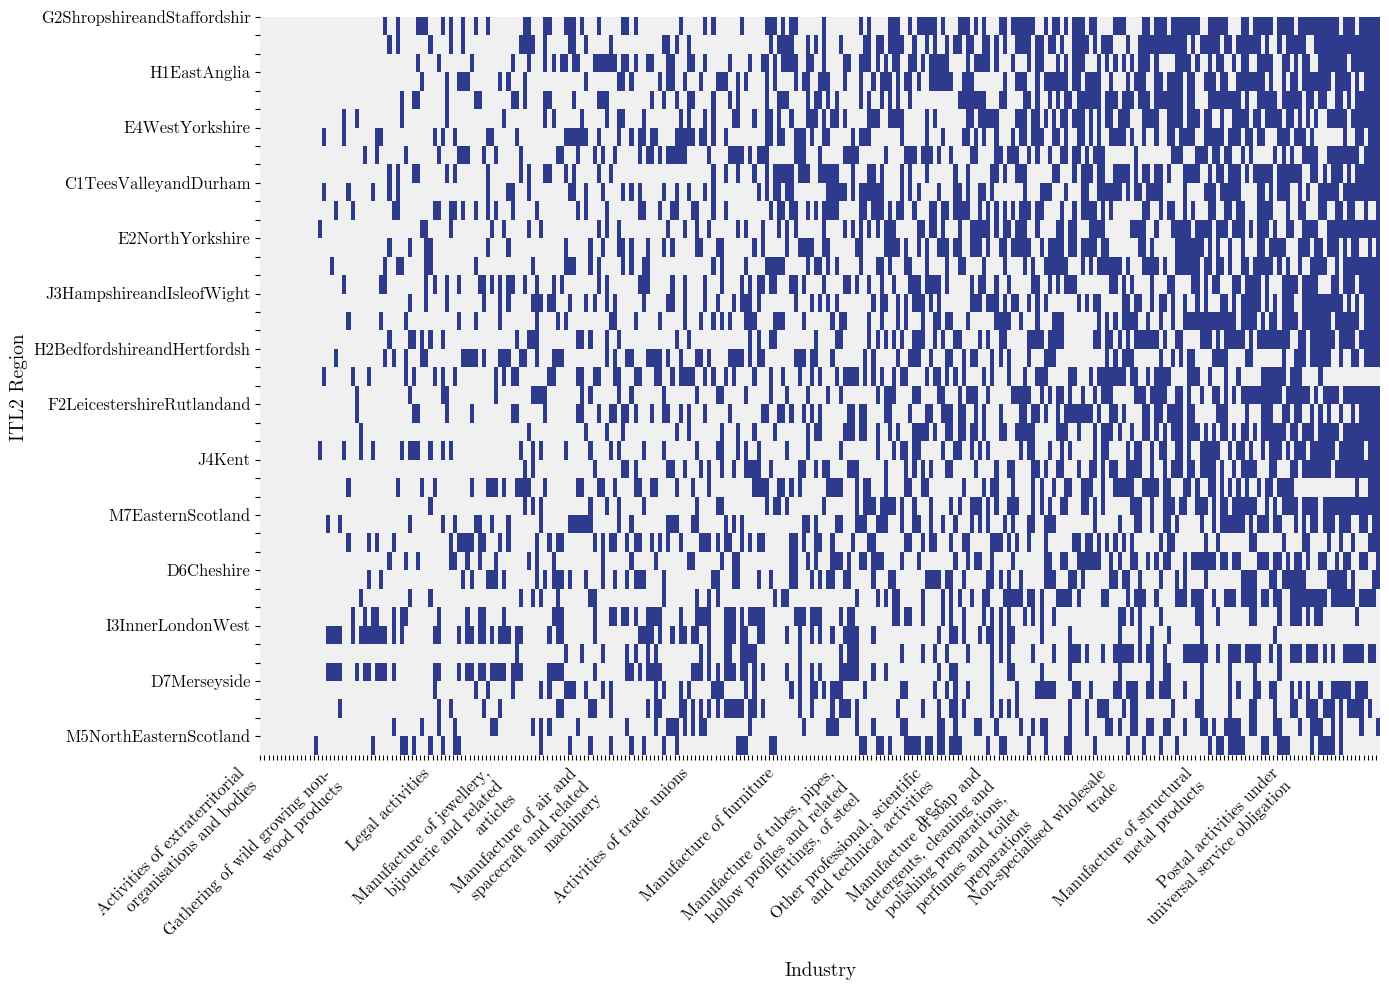

In [3]:
from matplotlib.colors import ListedColormap
import textwrap

# Reload the data
data_path = 'employment_region.csv'
data = pd.read_csv(data_path)

# Custom colour map for the binary data
binary_colormap_navy = ListedColormap(['#f0f0f0', '#2e3b8c'])

# Calculate row sums and sort the DataFrame based on row sums, highest sums at the top
row_sums = M_cp_matrix.sum(axis=1)
M_cp_matrix_sorted_rows = M_cp_matrix.loc[row_sums.sort_values(ascending=False).index]

# Calculate column sums and sort the columns based on these sums, largest column totals on the right
column_sums = M_cp_matrix_sorted_rows.sum(axis=0)
sorted_columns = column_sums.sort_values(ascending=True).index
M_cp_matrix_sorted = M_cp_matrix_sorted_rows[sorted_columns]

# Fix labels 
industries_cleaned = [i.split(': ')[-1] if ': ' in i else i for i in M_cp_matrix_sorted.columns]
industry_labels_sorted_subset = [industries_cleaned[i] if i % max(len(industries_cleaned) // 13, 1) == 0 else '' for i in range(len(industries_cleaned))]
industry_labels_sorted_subset_wrapped = ['\n'.join(textwrap.wrap(label, 30)) for label in industry_labels_sorted_subset]

regions_cleaned = M_cp_matrix_sorted.index.tolist()
regions_sorted_subset = [regions_cleaned[i] if i % max(len(regions_cleaned) // 12, 1) == 0 else '' for i in range(len(regions_cleaned))]
regions_final_sorted = [' '.join(region.split(' ')[1:]) if len(region) > 0 and region[0].isdigit() else region for region in regions_sorted_subset]

# Plot the heatmap 
plt.figure(figsize=(14, 10))
sns.heatmap(M_cp_matrix_sorted, annot=False, cmap=binary_colormap_navy, linewidths=0, cbar=False)

plt.title("", fontfamily='CMU Serif', fontsize=16)
plt.ylabel("ITL2 Region", fontfamily='CMU Serif', fontsize=14)
plt.xlabel("Industry", fontfamily='CMU Serif', fontsize=14)

plt.xticks(ticks=np.arange(len(industry_labels_sorted_subset_wrapped)), labels=industry_labels_sorted_subset_wrapped, rotation=45, ha="right", fontfamily='CMU Serif', fontsize=12)
plt.yticks(ticks=np.arange(len(regions_final_sorted)), labels=regions_final_sorted, rotation=0, fontfamily='CMU Serif', fontsize=12)

plt.tight_layout()
plt.show()


3. Compute proximity matrix and then ECI/PCI

In [4]:
# Step 1: Calculate Diversity (D) and Ubiquity (U)
diversity = M_cp_matrix.sum(axis=1)  # Sum across industries for each region
ubiquity = M_cp_matrix.sum(axis=0)  # Sum across regions for each industry

# Adding a small epsilon to avoid division by zero 
epsilon = 1e-9
diversity += epsilon
ubiquity += epsilon

# Step 2: Create Diagonal Matrices for D and U
D_matrix = np.diag(1 / diversity.values)  # Invert diversity values for the diagonal matrix
U_matrix = np.diag(1 / ubiquity.values)  # Invert ubiquity values for the diagonal matrix

# Step 3: Calculate the Modified Matrix M_tilde
# First, convert M_cp_matrix sto a NumPy array
M = M_cp_matrix.values

# Compute S = M U^-1 M^T
S = np.dot(np.dot(M, U_matrix), M.T)

# Calculate M_tilde = D^-1 S
M_tilde = np.dot(D_matrix, S)

# Normalise M_tilde to make it row-stochastic (each row sums to 1)
M_tilde_row_sums = M_tilde.sum(axis=1, keepdims=True)
M_tilde = M_tilde / M_tilde_row_sums

# Step 4: Compute Eigenvalues and Eigenvectors for M_tilde
eigenvalues, eigenvectors = np.linalg.eig(M_tilde.T)

# Step 5: Find the ECI as the Eigenvector Associated with the Second Largest Eigenvalue
sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort eigenvalues in descending order
second_largest_index = sorted_indices[1]  # Index of the second largest eigenvalue
eci_vector = eigenvectors[:, second_largest_index]  # Corresponding eigenvector

# Normalize the ECI vector
eci_normalized = (eci_vector - np.mean(eci_vector)) / np.std(eci_vector)

# Step 6: Create and Display the ECI DataFrame
eci = pd.DataFrame(eci_normalized, index=M_cp_matrix.index, columns=['ECI'])

print("ECI Preview:")
print(eci.head())


ECI Preview:
                                 ECI
itl2                                
C1TeesValleyandDurham      -0.736205
C2NorthumberlandandTyneand -0.362000
D1Cumbria                  -0.999730
D3GreaterManchester         0.702997
D4Lancashire               -0.710471


In [5]:
# Export ECI
#output_file_path = 'ECI_scores.csv'  

#eci.to_csv(output_file_path, index=True)  


/var/folders/8t/tpbcw7_d5k18f1xhtb_sl2cc0000gn/T/ipykernel_86294/2943918640.py:10: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/Users/joshuabailey/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


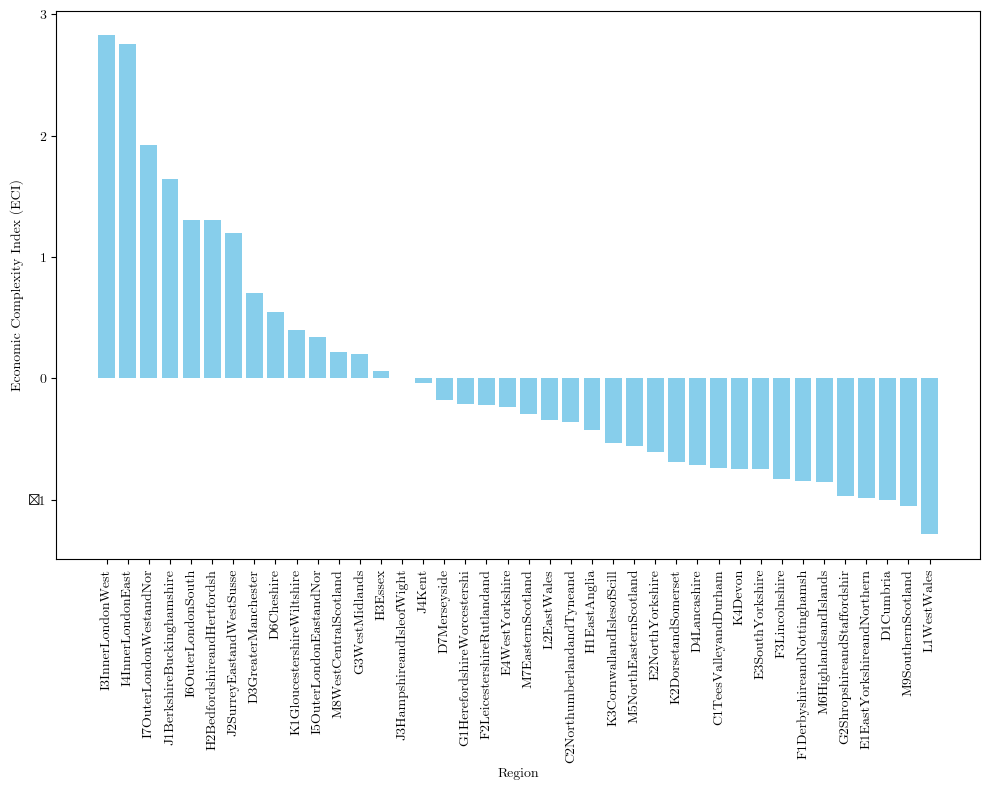

In [6]:
# Plot ECI 
eci_sorted = eci.sort_values(by='ECI', ascending=False)

plt.figure(figsize=(10, 8))
plt.bar(eci_sorted.index, eci_sorted['ECI'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Economic Complexity Index (ECI)')
plt.title('')
plt.tight_layout()  
plt.show()


/var/folders/8t/tpbcw7_d5k18f1xhtb_sl2cc0000gn/T/ipykernel_86294/94157975.py:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/Users/joshuabailey/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


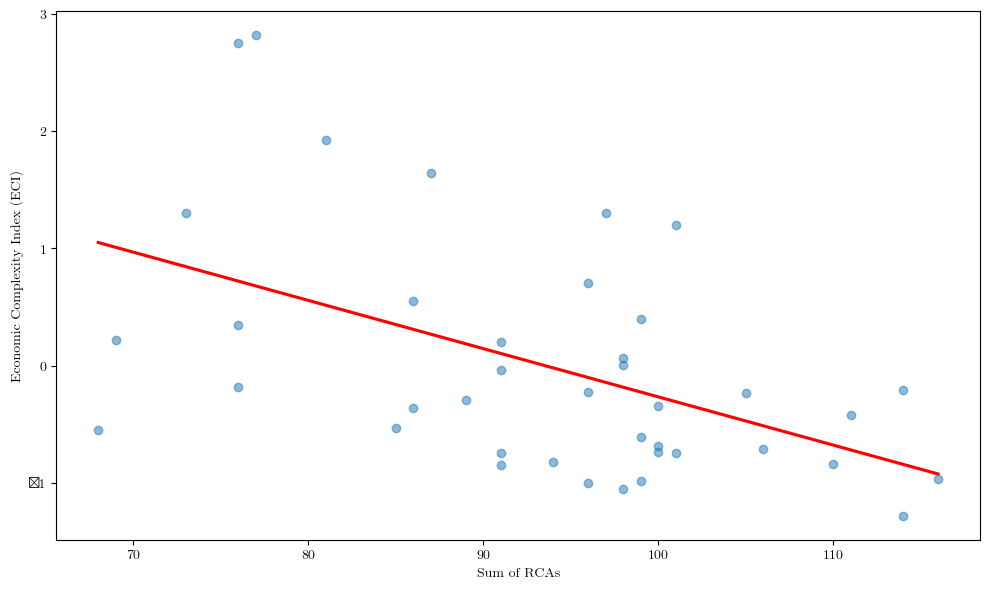

In [7]:
# Plot ECI and diversity

plt.rcParams.update({'font.family': 'CMU Serif'})

# Calculate row and column sums for sorting
row_sums = M_cp_matrix.sum(axis=1)
column_sums = M_cp_matrix.sum(axis=0)

# Sort M_cp_matrix by row sums and column sums
M_cp_matrix_sorted_rows = M_cp_matrix.loc[row_sums.sort_values(ascending=False).index]
M_cp_matrix_sorted = M_cp_matrix_sorted_rows.loc[:, column_sums.sort_values(ascending=True).index]

# Wrap industry labels over 30 characters
industry_labels = [textwrap.fill(label, 30) for label in M_cp_matrix_sorted.columns]


# Compute ECI and RCA sum for plotting
RCA_sum = M_cp_matrix.sum(axis=1)  

# Prepare the plot  
plot_data = pd.DataFrame({
    'Sum of RCAs': RCA_sum,  
    'ECI': eci['ECI']        
}).reset_index(drop=True)

# Plot ECI against Sum of RCAs with a linear fit
plt.figure(figsize=(10, 6))
sns.regplot(x='Sum of RCAs', y='ECI', data=plot_data, ci=None, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('', fontfamily='CMU Serif')
plt.xlabel('Sum of RCAs', fontfamily='CMU Serif')
plt.ylabel('Economic Complexity Index (ECI)', fontfamily='CMU Serif')
plt.grid(False)
plt.tight_layout()
plt.show()




In [8]:
# Export ECI/RCA
#output_file_path = 'eci_rca.csv' 

#plot_data.to_csv(output_file_path, index=False)

